In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os

## A sample Image

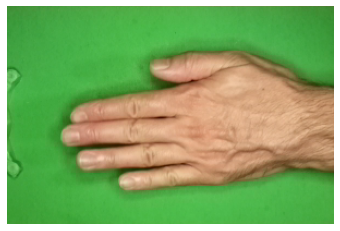

In [2]:
sample = image.load_img("../input/rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png")
plt.imshow(sample)
plt.axis("off")
plt.show()

In [3]:
X_train = []
labels = []

labels_dict = {
    "paper" : 0,
    "rock" : 1,
    "scissors" : 2
}

filepath = "../input/rockpaperscissors"

for file in os.listdir(filepath):
    
    if file in labels_dict.keys():
        
        for img_path in os.listdir(os.path.join(filepath, file)):
            
            img = image.load_img(os.path.join(filepath, file, img_path), target_size=(224,224))
            img = image.img_to_array(img)/255.0
            
            X_train.append(img)
            labels.append(labels_dict[file])

X_train = np.array(X_train)

In [4]:
len(X_train), len(labels)

(2188, 2188)

## Model Prep
- Will use ResNet50 Model
- Will implement Transfer learning

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import *
from keras.models import Model

In [6]:
model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [7]:
# We are using the Convolution base of ResNet50 model
# and will add the dense layers according to our classifier
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256, activation='relu')(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(3, activation='softmax')(d1)

In [8]:
model_new = Model(inputs= model.input, outputs = fc2)

In [9]:
# FINE TUNING the model
for ix in range(169):

    model_new.layers[ix].trainable = False

# Compiling the model after freezing

adam = Adam(learning_rate=0.00003)
model_new.compile(
    loss= 'categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

In [11]:
# One hot encoded labels
from keras.utils import np_utils
Y_train = np_utils.to_categorical(labels)

In [12]:
hist = model_new.fit(X_train,
                     Y_train,
                     shuffle= True,
                     batch_size= 16,
                     epochs= 20,
                     validation_split= 0.15,
                     callbacks=[checkpoint]
                     )

Epoch 1/20
117/117 [==============================] - 7s 57ms/step - loss: 1.0897 - accuracy: 0.4658 - val_loss: 1.0354 - val_accuracy: 0.0000e+00
Epoch 2/20
117/117 [==============================] - 5s 45ms/step - loss: 0.8644 - accuracy: 0.6471 - val_loss: 0.9128 - val_accuracy: 0.9514
Epoch 3/20
117/117 [==============================] - 6s 47ms/step - loss: 0.6856 - accuracy: 0.7725 - val_loss: 0.8972 - val_accuracy: 0.7903
Epoch 4/20
117/117 [==============================] - 6s 47ms/step - loss: 0.5385 - accuracy: 0.8322 - val_loss: 0.6835 - val_accuracy: 0.9058
Epoch 5/20
117/117 [==============================] - 5s 46ms/step - loss: 0.4267 - accuracy: 0.8833 - val_loss: 0.5160 - val_accuracy: 0.8207
Epoch 6/20
117/117 [==============================] - 5s 41ms/step - loss: 0.3758 - accuracy: 0.8924 - val_loss: 0.7280 - val_accuracy: 0.6809
Epoch 7/20
117/117 [==============================] - 5s 46ms/step - loss: 0.3135 - accuracy: 0.9096 - val_loss: 0.4247 - val_accuracy: 0.

In [13]:
# Loading the best model
model_new.load_weights("./best_model.h5")

## Visulaising Loss and Accuracy

In [14]:
h = hist.history
plt.style.use('seaborn')

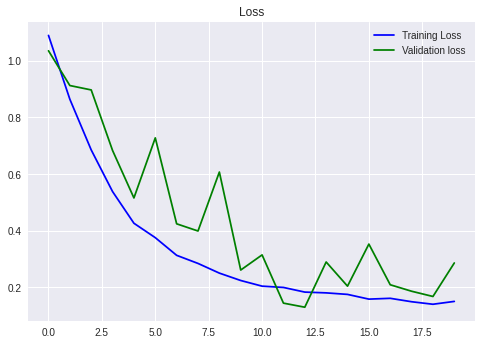

In [15]:
plt.plot(h['loss'], c='blue', label='Training Loss')
plt.plot(h['val_loss'], c= 'green', label= 'Validation loss')
plt.title("Loss")
plt.legend()
plt.show()

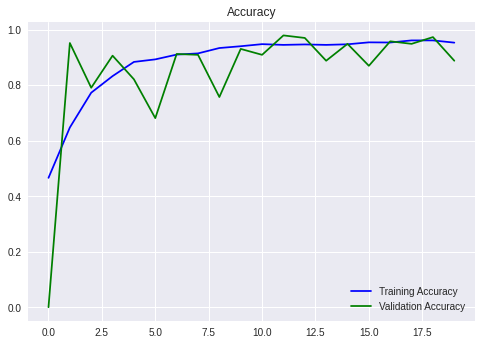

In [16]:
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c= 'green', label= 'Validation Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

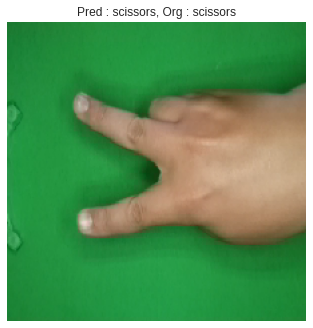

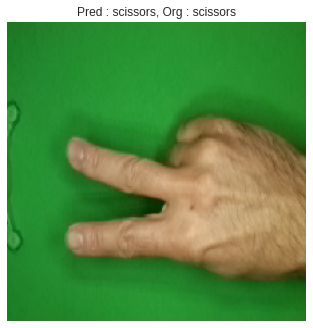

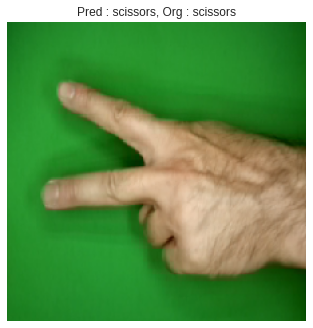

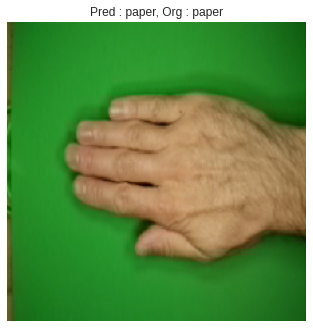

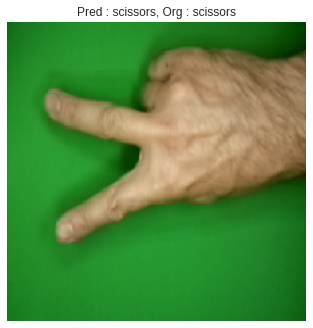

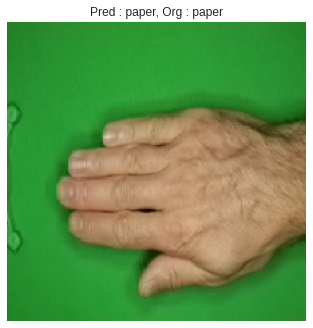

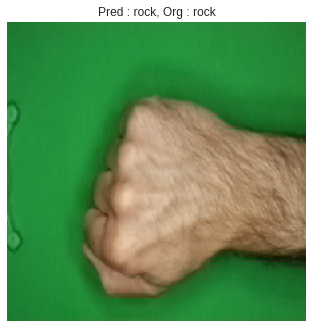

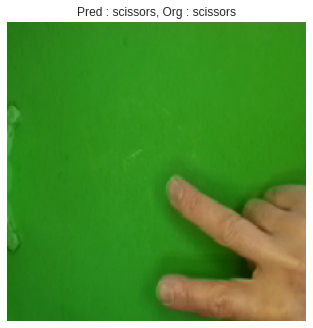

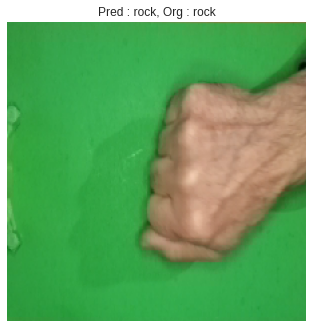

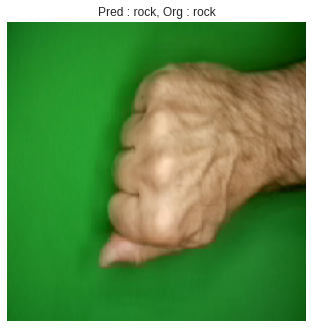

In [17]:
## Testing some random samples

rev_label_dict = dict([(value, key) for (key, value) in labels_dict.items()])

import random

for i in range(10):
    idx = random.randint(0, len(X_train))
    plt.imshow(X_train[idx])
    plt.axis("off")
    pred = rev_label_dict.get(np.argmax(model_new.predict(X_train[idx].reshape(1,224,224,3))))
    org = rev_label_dict.get(labels[idx])
    plt.title("Pred : {}, Org : {}".format(pred, org))
    plt.show()